In [ ]:
!pip install numpy==1.19.3
!pip install mediapipe

In [1]:
import cv2
import mediapipe as mp
import pathlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

2023-02-22 21:30:18.516743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-22 21:30:18.625149: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/lucassoares/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-22 21:30:18.625166: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-22 21:30:19.235495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [3]:
# For webcam input:
video_path = "./training_session_1.mp4"
cap = cv2.VideoCapture(video_path)
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = pathlib.Path(video_path).stem + "_pose.mp4" 
print(output_path)

training_session_1_pose.mp4


In [4]:
pose_coords = []
# For video input
out = cv2.VideoWriter(output_path, fourcc, 30.0, (frame_width, frame_height))
with mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      break
    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image)
    # mp_drawing.plot_landmarks(
    #     results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    #pose_coords.append(results.pose_landmarks)
    pose_coords.append(results)
    # Draw the pose annotation on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    # Flip the image horizontally for a selfie-view display.
    #cv2_imshow(cv2.flip(image, 1))
    out.write(cv2.flip(image, 1))
    if cv2.waitKey(5) & 0xFF == 27:
      break
cap.release()
out.release()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Ignoring empty camera frame.


In [22]:
left_foot_coords = [pose_coords[i].landmark[31] for i in range(len(pose_coords))]
right_foot_coords = [pose_coords[i].landmark[32] for i in range(len(pose_coords))]

/home/lucassoares/anaconda3/envs/explore/lib/python3.10/site-packages/matplotlib/animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


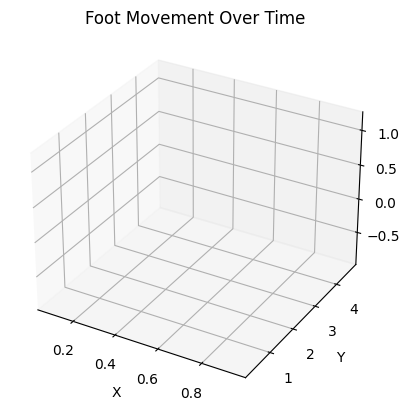

In [27]:
# import matplotlib.pyplot as plt

# # Assume `coords` is a list of tuples containing the x, y, and z coordinates of the left shoulder over time
# # The x, y, and z coordinates should be in separate lists
# x_coords = [coord.x for coord in left_foot_coords]
# y_coords = [coord.y for coord in left_foot_coords]
# z_coords = [coord.z for coord in left_foot_coords]

# x_coords_right = [coord.x for coord in right_foot_coords]
# y_coords_right = [coord.y for coord in right_foot_coords]
# z_coords_right = [coord.z for coord in right_foot_coords]


# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x_coords, y_coords, z_coords)
# ax.scatter(x_coords_right, y_coords_right, z_coords_right)
# # Set the axis labels
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # Set the title
# ax.set_title('Left Shoulder Movement Over Time')

# # Show the plot
# plt.show()



# Assume `left_foot_coords` and `right_foot_coords` are lists of tuples containing the x, y, and z coordinates of the left and right foot over time
# The x, y, and z coordinates should be in separate lists
x_coords = [coord.x for coord in left_foot_coords]
y_coords = [coord.y for coord in left_foot_coords]
z_coords = [coord.z for coord in left_foot_coords]

x_coords_right = [coord.x for coord in right_foot_coords]
y_coords_right = [coord.y for coord in right_foot_coords]
z_coords_right = [coord.z for coord in right_foot_coords]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Foot Movement Over Time')

def update(frame):
    ax.clear()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Foot Movement Over Time')
    ax.scatter(x_coords[:frame], y_coords[:frame], z_coords[:frame])
    ax.scatter(x_coords_right[:frame], y_coords_right[:frame], z_coords_right[:frame])

ani = FuncAnimation(fig, update, frames=len(x_coords), interval=5)
ani.save('animation.mp4', writer='ffmpeg', fps=30)
#plt.show()

In [5]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

_PRESENCE_THRESHOLD = 0.5
_VISIBILITY_THRESHOLD = 0.5


def plot_landmarks(
    landmark_list,
    connections=None,
):
    if not landmark_list:
        return
    plotted_landmarks = {}
    for idx, landmark in enumerate(landmark_list.landmark):
        if (
            landmark.HasField("visibility")
            and landmark.visibility < _VISIBILITY_THRESHOLD
        ) or (
            landmark.HasField("presence") and landmark.presence < _PRESENCE_THRESHOLD
        ):
            continue
        plotted_landmarks[idx] = (-landmark.z, landmark.x, -landmark.y)
    if connections:
        out_cn = []
        num_landmarks = len(landmark_list.landmark)
        # Draws the connections if the start and end landmarks are both visible.
        for connection in connections:
            start_idx = connection[0]
            end_idx = connection[1]
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(
                    f"Landmark index is out of range. Invalid connection "
                    f"from landmark #{start_idx} to landmark #{end_idx}."
                )
            if start_idx in plotted_landmarks and end_idx in plotted_landmarks:
                landmark_pair = [
                    plotted_landmarks[start_idx],
                    plotted_landmarks[end_idx],
                ]
                out_cn.append(
                    dict(
                        xs=[landmark_pair[0][0], landmark_pair[1][0]],
                        ys=[landmark_pair[0][1], landmark_pair[1][1]],
                        zs=[landmark_pair[0][2], landmark_pair[1][2]],
                    )
                )
        cn2 = {"xs": [], "ys": [], "zs": []}
        for pair in out_cn:
            for k in pair.keys():
                cn2[k].append(pair[k][0])
                cn2[k].append(pair[k][1])
                cn2[k].append(None)

    df = pd.DataFrame(plotted_landmarks).T.rename(columns={0: "z", 1: "x", 2: "y"})
    df["lm"] = df.index.map(lambda s: mp_pose.PoseLandmark(s).name).values
    fig = (
        px.scatter_3d(df, x="z", y="x", z="y", hover_name="lm")
        .update_traces(marker={"color": "red"})
        .update_layout(
            margin={"l": 0, "r": 0, "t": 0, "b": 0},
            scene={"camera": {"eye": {"x": 2.1, "y": 0, "z": 0}}},
        )
    )
    fig.add_traces(
        [
            go.Scatter3d(
                x=cn2["xs"],
                y=cn2["ys"],
                z=cn2["zs"],
                mode="lines",
                line={"color": "black", "width": 5},
                name="connections",
            )
        ]
    )

    return fig

In [10]:

plot_landmarks(pose_coords[200].pose_landmarks,  mp_pose.POSE_CONNECTIONS)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


# position_index = 0
# landmarks = pose_coords[position_index].landmark
# x = [landmark.x for landmark in landmarks]
# y = [landmark.y for landmark in landmarks]
# z = [landmark.z for landmark in landmarks]

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z)
# plt.show()

/home/lucassoares/anaconda3/envs/explore/lib/python3.10/site-packages/matplotlib/animation.py:1732: UserWarning: Can not start iterating the frames for the initial draw. This can be caused by passing in a 0 length sequence for *frames*.

If you passed *frames* as a generator it may be exhausted due to a previous display or save.
  warnings.warn(


ValueError: Indices for islice() must be None or an integer: 0 <= x <= sys.maxsize.

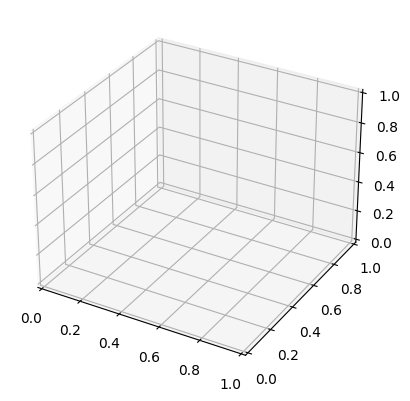

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(i):
    ax.clear()
    try:
        landmarks = pose_coords[i].landmark
        x = [landmark.x for landmark in landmarks]
        y = [landmark.y for landmark in landmarks]
        z = [landmark.z for landmark in landmarks]
        ax.scatter(x, y, z)
        # # Plot lines connecting the keypoints
        # lines = [
        #     (0, 1), (0, 15), (0, 16), (1, 2), (1, 5), (1, 8), (2, 3),
        #     (3, 4), (5, 6), (6, 7), (8, 9), (8, 12), (9, 10), (10, 11),
        #     (11, 22), (11, 24), (12, 13), (13, 14), (14, 19), (14, 21),
        #     (15, 17), (16, 18), (19, 20), (22, 23), (24, 25)
        # ]
        
        # for line in lines:
        #     ax.plot([x[line[0]], x[line[1]]], [y[line[0]], y[line[1]]], [z[line[0]], z[line[1]]])
    except:
        print(i)

ani = FuncAnimation(fig, update, frames=len(pose_coords)-5, interval=5)
ani.save('animation.mp4', writer='ffmpeg', fps=30)

The pose landmarks are this:

Another list of pose landmarks in world coordinates. Each landmark consists of the following:

x, y and z: Real-world 3D coordinates in meters with the origin at the center between hips.
visibility: Identical to that defined in the corresponding

[source](https://google.github.io/mediapipe/solutions/pose.html)

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import os

# Input video path
save_path = "./uchimata_wall_pose.mp4"

# Compressed video path
compressed_path = f"./{save_path[:-4]}_compressed.mp4"

os.system(f"ffmpeg -i {save_path} -vcodec libx264 {compressed_path}")

In [ ]:
# Show video
mp4 = open(compressed_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)